In [1]:
import os
import sys

import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd
from models.TrainPlanningOperator2D import PlanningOperator2D
from heuristics import generaterandompos
from heuristics import euclideannorm, FMM, dijkstra, planningoperator, manhattandistance
from heuristics import testheuristiconmaps, testheuristiconsinglemap



Load Test Maps

In [2]:
Ntotal = 550
ntest = 50
ntrain = 250
sub = 1
Sx = Sy = int(((512 - 1) / sub) + 1)
maps = np.load('/mountvol/2D-512-Dataset-0/mask.npy')
maps = maps[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]
# maps = maps[30:31,:,:].reshape(1,Sx,Sy)

Generate Random Start and Goal Positions on Maps

In [3]:
startpositions = generaterandompos(maps)
goalpositions = generaterandompos(maps)

Comparing Euclidean and Manhattan Distance

In [4]:
# Euclidean Norm
print("Testing Euclidean Norm")
euclidean_results = testheuristiconmaps(startpositions, goalpositions, maps, euclideannorm, plotresults=False, printvalues=True)


Testing Euclidean Norm
Average Path Cost: 307.71254239288857 
Average Planning Time: 0.9417709159851074 
Average Inference Time: 0.007653656005859375 
Average Number of Node Expansions: 15525.56 
Average Success Rate: 1.0


In [5]:
# Manhattan Distance
print("Testing Manhattan Distance")
manhattan_results = testheuristiconmaps(startpositions, goalpositions, maps, manhattandistance, plotresults=False, printvalues=True)

Testing Manhattan Distance
Average Path Cost: 311.30935480155983 
Average Planning Time: 0.2387600374221802 
Average Inference Time: 0.0017703866958618164 
Average Number of Node Expansions: 3767.74 
Average Success Rate: 1.0


Planning Operator

In [3]:
# Model
modes = 8
width = 24
nlayers = 1

model = PlanningOperator2D(modes, modes, width, nlayers)
model.load_state_dict(torch.load("/mountvol/2D-512-Dataset-0/planningoperator_street_maps_512x512_8m_12w_1l_b20/n500_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model256.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

erosion_values = []
avgpathcost_values = []
avgplantime_values = []
avginfertime_values = []
avgnodesexp_values = []
avgsuccessrate_values = []



/tmp/ipykernel_16321/697047691.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/mountvol/2D-512-Dataset-0/planningoperator_street_maps_

100%|██████████| 29/29 [01:24<00:00,  2.91s/it]


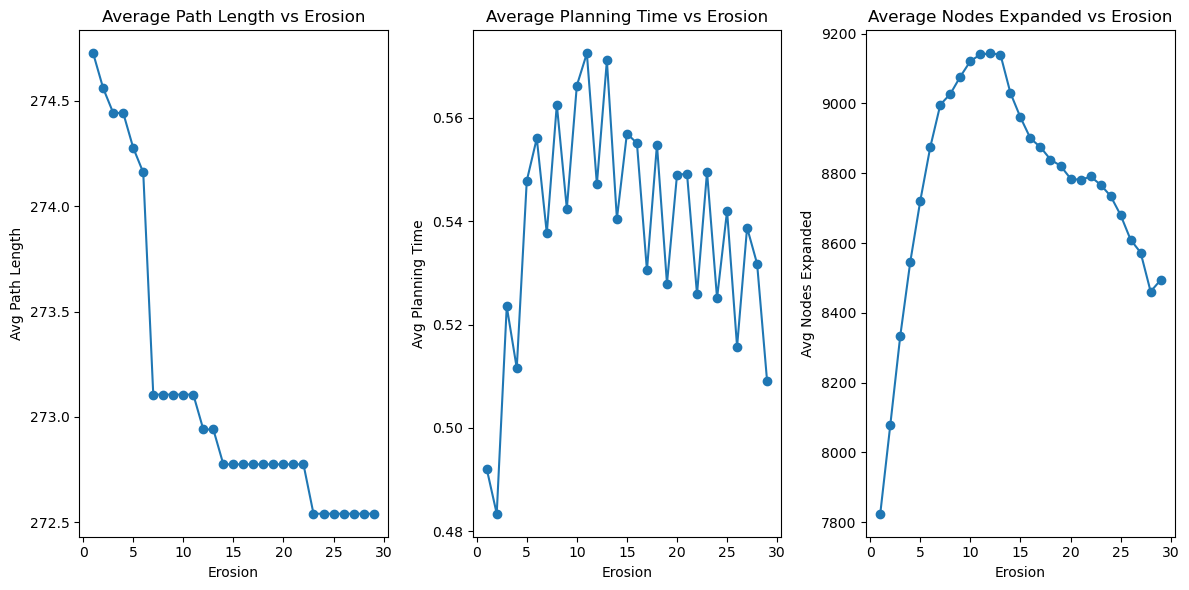

In [7]:

from tqdm import tqdm 

erosionmaps = maps[::10, :, :]
erosionstartpos = startpositions[::10,:]
erosiongoalpos = goalpositions[::10,:]

erosion_values = []
avgpathcost_values = []
avgplantime_values = []
avginfertime_values = []
avgnodesexp_values = []
avgsuccessrate_values = []

# Run the loop and store results
for erode in tqdm(range(1, 30)):
    
    # Call your function and store the results
    avgpathcost, avgplantime, avginfertime, avgnodesexp, avgsuccessrate = testheuristiconmaps(
        erosionstartpos, erosiongoalpos, erosionmaps, planningoperator, model=model, erosion=erode, plotresults=False, printvalues=False
    )
    
    # Append results to lists
    erosion_values.append(erode)
    avgpathcost_values.append(avgpathcost)
    avgplantime_values.append(avgplantime)
    avginfertime_values.append(avginfertime)
    avgnodesexp_values.append(avgnodesexp)
    avgsuccessrate_values.append(avgsuccessrate)

plt.figure(figsize=(12, 6))

# Plot for avgpathcost (Average Path Length)
plt.subplot(1, 3, 1)
plt.plot(erosion_values, avgpathcost_values, marker='o')
plt.title('Average Path Length vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Path Length')

# Plot for avgplantime (Average Planning Time)
plt.subplot(1, 3, 2)
plt.plot(erosion_values, avgplantime_values, marker='o')
plt.title('Average Planning Time vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Planning Time')

# Plot for avgnodesexp (Average Nodes Expanded)
plt.subplot(1, 3, 3)
plt.plot(erosion_values, avgnodesexp_values, marker='o')
plt.title('Average Nodes Expanded vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Nodes Expanded')

plt.tight_layout()
plt.show()

In [8]:
print("Testing PNO")
no_results = testheuristiconmaps(startpositions, goalpositions, maps, planningoperator, plotresults=False, printvalues=True, erosion = 20, model=model)

Testing PNO


Average Path Cost: 307.8176390728075 
Average Planning Time: 0.6623843383789062 
Average Inference Time: 0.03353368282318115 
Average Number of Node Expansions: 10558.34 
Average Success Rate: 1.0


In [9]:
import pickle
data = {
    "startpositions": startpositions,
    "goalpositions": goalpositions,
    "maps": maps,
    "euclidean_results": euclidean_results,
    "no_results": no_results,
    "erosion_values": erosion_values,
    "avgpathcost_values": avgpathcost_values,
    "avgplantime_values": avgplantime_values,
    "avginfertime_values": avginfertime_values,
    "avgnodesexp_values": avgnodesexp_values,
    "avgsuccessrate_values": avgsuccessrate_values
}

# Save to file using pickle, ignoring the model
with open("512mapstest.pkl", "wb") as file:
    pickle.dump(data, file)

print("Data saved successfully to '256maps.pkl'")

Data saved successfully to '256maps.pkl'


Test Single Maps

Plotting Euclidean Norm
Average Path Cost: 387.24978336205635 
Average Planning Time: 1.1043202877044678 
Average Inference Time: 0.010674476623535156 
Average Number of Node Expansions: 19187.0 
Average Success Rate: 1.0


(387.24978336205635, 1.1043202877044678, 0.010674476623535156, 19187.0, 1.0)

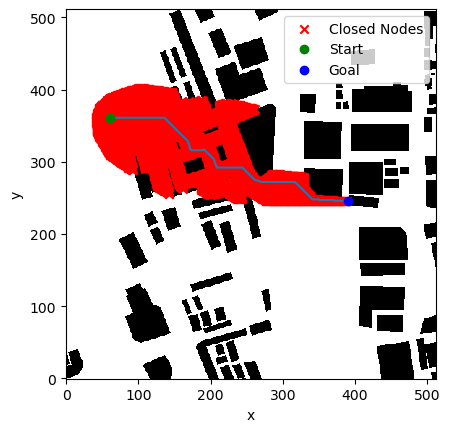

In [9]:
maptest = maps[0,:,:].reshape(1,Sx,Sy)
starttest = generaterandompos(maptest)
goaltest = generaterandompos(maptest)
print("Plotting Euclidean Norm")
testheuristiconmaps(starttest, goaltest, maptest, euclideannorm, plotresults=True, printvalues=True)

Plotting PNO
Average Path Cost: 400.66399692442974 
Average Planning Time: 0.6807873249053955 
Average Inference Time: 0.0451352596282959 
Average Number of Node Expansions: 11269.0 
Average Success Rate: 1.0


(400.66399692442974, 0.6807873249053955, 0.0451352596282959, 11269.0, 1.0)

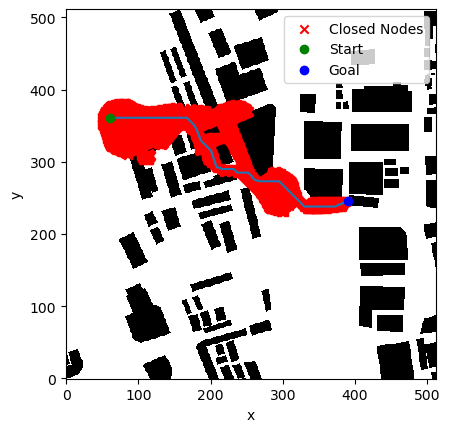

In [10]:
print("Plotting PNO")
testheuristiconmaps(starttest, goaltest, maptest, planningoperator, plotresults=True, printvalues=True, erosion = 1, model=model)